Own Code Lines	79
External Code Lines	29
Existing Accuracy	77% using CNN, NA for SVM
Our Accuracy	76%
Time to run	140 min

# Skin Cancer Detection and Classification using Support Vector Machine

We will build a non-linear SVM model (using non-linear RBF kernel) and then find the optimal hyperparameters (the choice of kernel, C, gamma).

### Initialization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('..', 'input')
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor
import pickle
from PIL import Image

In [2]:
base_skin_dir = 'F:\MIS\Data Science\Project\HAM 10000'

In [3]:
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
cancer_type_dict = {
    'nv': 'Cancer',
    'mel': 'Cancer',
    'bkl': 'Non Cancer',
    'bcc': 'Cancer',
    'akiec': 'Cancer',
    'vasc': 'Cancer',
    'df': 'Non Cancer'
}

### Reading & Processing data

In this step we have read the csv by joining the path of image folder which is the base folder where all the images are placed named base_skin_dir. After that we made some new columns which is easily understood for later reference such as we have made column path which contains the image_id, cell_type which contains the short name of lesion type and at last we have made the categorical column cell_type_idx in which we have categorize the lesion type in to codes from 0 to 6

In [7]:
# Creating New Columns for better readability

tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cancer_type'] = tile_df['dx'].map(cancer_type_dict.get) 
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df['cancer_type_idx'] = pd.Categorical(tile_df['cancer_type']).codes

# Now lets see the sample of tile_df to look on newly made columns
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cancer_type,cell_type,cell_type_idx,cancer_type_idx
1308,HAM_0004643,ISIC_0029651,mel,histo,65.0,male,back,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Cancer,dermatofibroma,6,0
5501,HAM_0003473,ISIC_0024417,nv,follow_up,75.0,male,trunk,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Cancer,Melanocytic nevi,4,0
6038,HAM_0005999,ISIC_0030958,nv,follow_up,50.0,female,foot,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Cancer,Melanocytic nevi,4,0


In [8]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cancer_type,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,2,7
top,HAM_0000835,ISIC_0028500,nv,histo,male,back,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Cancer,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,8801,6705


### Data Cleaning

In [39]:
tile_df.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                54
sex                 0
localization        0
path                0
cancer_type         0
cell_type           0
cell_type_idx       0
cancer_type_idx     0
image               0
dtype: int64

#### As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.

In [41]:
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

### Exporatory Data Analysis

In thissection we will explore different features of the dataset , their distrubtions and actual counts

#### Plot to see distribution of 7 different classes of cell type

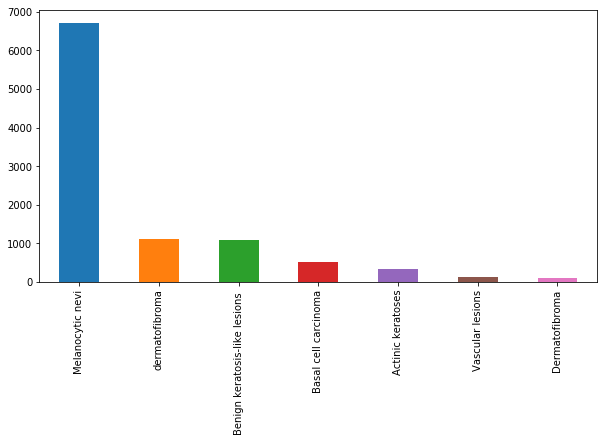

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

#### Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

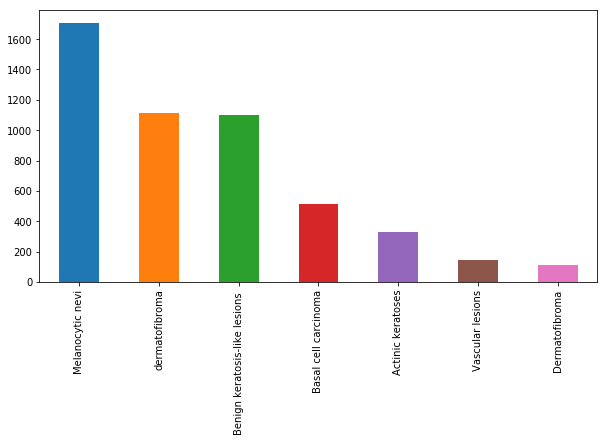

In [10]:
# Let's balance it a bit!

tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

### Loading and resizing of images

In this step images will be loaded into the column named image from the image path from the image folder.

In [11]:
# load in all of the images
from skimage.io import imread
tile_df['image'] = tile_df['path'].map(imread)

In [12]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    5015
Name: image, dtype: int64

In [16]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cancer_type,cell_type,cell_type_idx,cancer_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Non Cancer,Benign keratosis-like lesions,2,1,"[[[188, 147, 191], [186, 148, 189], [187, 150,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Non Cancer,Benign keratosis-like lesions,2,1,"[[[25, 15, 23], [25, 14, 22], [25, 14, 22], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Non Cancer,Benign keratosis-like lesions,2,1,"[[[186, 128, 140], [188, 128, 136], [183, 126,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Non Cancer,Benign keratosis-like lesions,2,1,"[[[24, 9, 16], [22, 11, 15], [23, 11, 15], [26..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,F:\MIS\Data Science\Project\HAM 10000\HAM10000...,Non Cancer,Benign keratosis-like lesions,2,1,"[[[122, 80, 102], [124, 82, 104], [127, 83, 10..."


#### Display images of each cell type

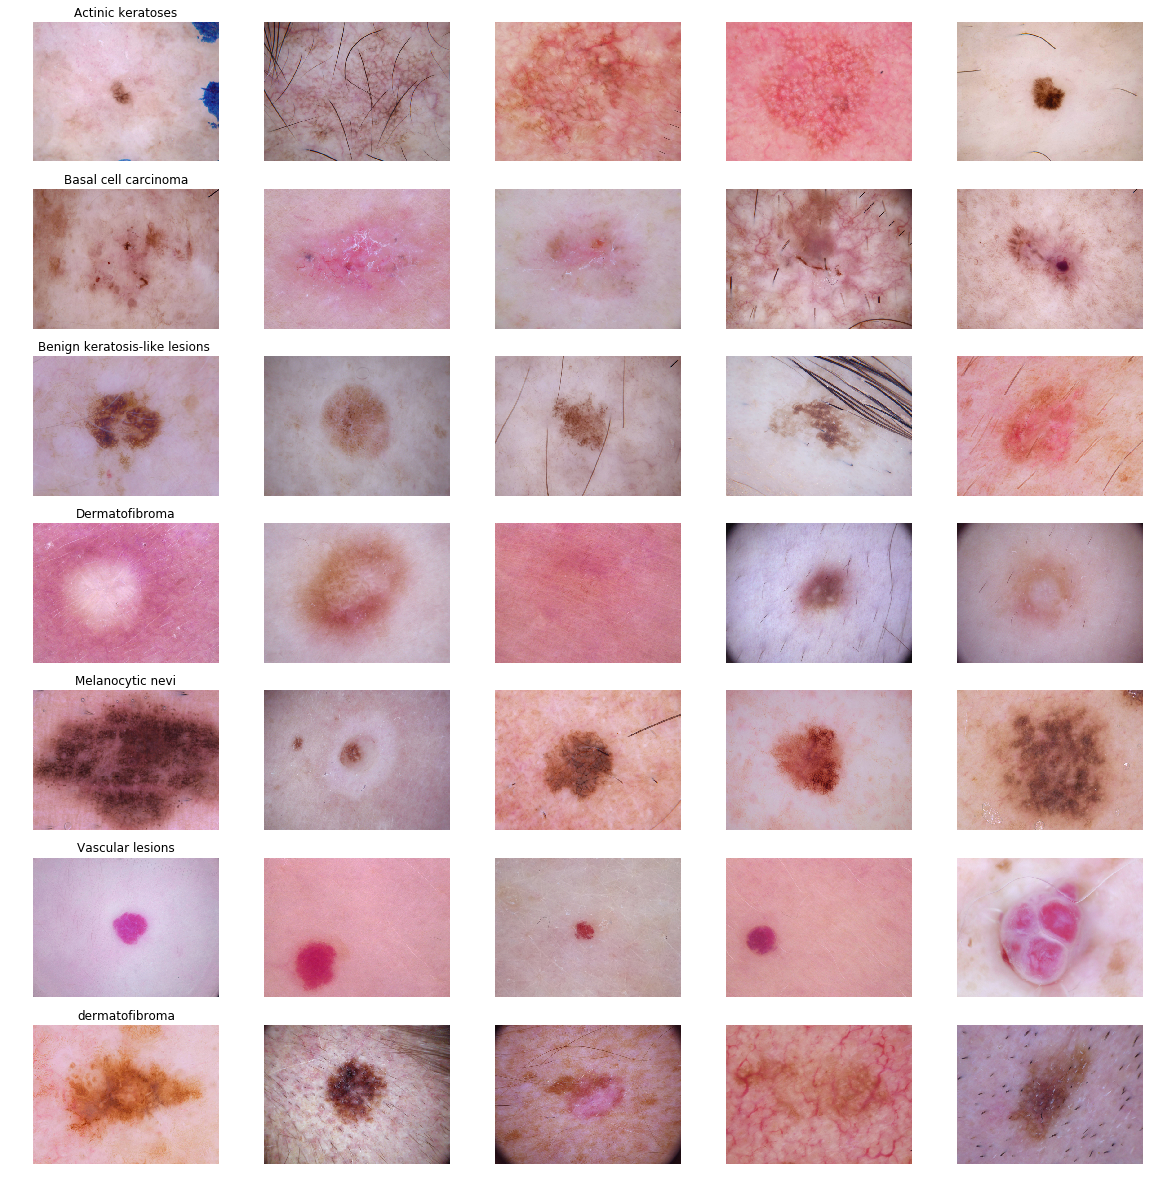

In [201]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [202]:
len(tile_df['image'])

5015

### Feature extraction for Image Classification

Here we are extracting LBP, GLCM and Gabor Filter response features for each image of our dataset. These features are fed to SVM classifier later for classification.

In [229]:
# Generating training data by extracting features from all images
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(tile_df['image']),featLength)) #Feature vector of each image is of size 1x1030
lbp_features = np.zeros((len(tile_df['image']),2))
glcm_features = np.zeros((len(tile_df['image']),5))
gabor_features = np.zeros((len(tile_df['image']),2))
for tr in range(len(tile_df['image'])):
#     print(str(tr+1)+'/'+str(len(tile_df['image'])))
    img = Image.fromarray(tile_df['image'][tr]) #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob))) 
    lbp_features[tr,:] = [lbp_energy,lbp_entropy]
#     lbp_features.append(tile_df['cell_type_idx'][tr])
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    glcm_features[tr,:] = feat_glcm
#     glcm_features.append(tile_df['cell_type_idx'][tr])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    gabor_features[tr,:] = [gabor_energy,gabor_entropy]
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[tr,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(tile_df['cancer_type_idx'][tr])
trainLabel = np.array(label) #Conversion from list to array

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log2
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


In [18]:
# tile_df = tile_df.reset_index(drop=True)
# # Generating training data by extracting features from all images
# label = []
# for tr in range(len(tile_df['image'])):
#     # Class label
#     label.append(tile_df['cancer_type_idx'][tr])
# trainLabel = np.array(label)

In [231]:
# Save features in csv format for future reference

np.savetxt("lbp_features.csv", lbp_features, delimiter=",")
np.savetxt("glcm_features.csv", glcm_features, delimiter=",")
np.savetxt("gabor_features.csv", gabor_features, delimiter=",")
np.savetxt("train_features.csv", trainFeats, delimiter=",")
np.savetxt("train_labels.csv", trainLabel, delimiter=",")

In [6]:
np.savetxt("train_labels_cancer.csv", trainLabel, delimiter=",")

NameError: name 'trainLabel' is not defined

In [12]:
training_data = pd.read_csv('train_features.csv')

In [8]:
training_data.head()

,Feature,Feature.1,Feature.2,Feature.3,Feature.4,Feature.5,Feature.6,Feature.7,Feature.8,Cancer_Type
0,0.164,2.70,26.0,3.57,0.273,0.0353,0.961,0.444,1.420,1.0
1,0.173,2.66,33.7,4.00,0.242,0.0265,0.986,0.414,1.490,1.0
2,0.175,2.64,26.2,3.48,0.272,0.0358,0.952,0.808,0.592,1.0
3,0.163,2.71,77.3,5.59,0.198,0.0240,0.965,0.603,1.020,1.0
4,0.195,2.55,43.2,3.68,0.316,0.0257,0.987,0.370,1.520,1.0


In [9]:
trainLabel = training_data['Cancer_Type']

In [10]:
trainLabel

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
5010    0.0
5011    0.0
5012    0.0
5013    0.0
5014    0.0
Name: Cancer_Type, Length: 5015, dtype: float64

In [13]:
X = training_data.drop('Cancer_Type',axis=1)

# Putting response variable to y
y = training_data['Cancer_Type']

In [14]:
training_data = training_data.drop('Cancer_Type',axis=1)

In [15]:
training_data.head()

,Feature,Feature.1,Feature.2,Feature.3,Feature.4,Feature.5,Feature.6,Feature.7,Feature.8
0,0.164,2.70,26.0,3.57,0.273,0.0353,0.961,0.444,1.420
1,0.173,2.66,33.7,4.00,0.242,0.0265,0.986,0.414,1.490
2,0.175,2.64,26.2,3.48,0.272,0.0358,0.952,0.808,0.592
3,0.163,2.71,77.3,5.59,0.198,0.0240,0.965,0.603,1.020
4,0.195,2.55,43.2,3.68,0.316,0.0257,0.987,0.370,1.520


In [16]:
training_data = training_data.values

In [17]:
training_data.shape

(5015, 9)

In [18]:
# Normalizing the train features to the range [0,1]

trMaxs = np.amax(training_data,axis=0) #Finding maximum along each column
trMins = np.amin(training_data,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(5015,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(5015,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(training_data-trMins_rep,trMaxs_rep) #Element-wise division

### Train Test Split

In this step we have splitted the dataset into training and testing set of 70:30 ratio

In [19]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(trainFeatsNorm, y, test_size = 0.3, random_state = 4)

## Model Building

In [20]:
from sklearn.svm import SVC
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\anish\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [21]:
from sklearn import metrics
# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred, average = None))

accuracy 0.7588039867109635
precision [0.75880399 0.        ]


C:\Users\anish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Hyperparameter Tuning 

Now, we have multiple hyperparameters to optimise - 
- The choice of kernel (linear, rbf etc.)
- C
- gamma

We'll use the ```GridSearchCV()``` method to tune the hyperparameters. 

## Grid Search to Find Optimal Hyperparameters

Let's first use the RBF kernel to find the optimal C and gamma (we can consider the kernel as a hyperparameter as well, though training the model will take an exorbitant amount of time). 

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters

# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)             

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   15.4s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [23]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.7575498575498576 corresponding to hyperparameters {'C': 1, 'gamma': 0.01}


In [24]:
# specify optimal hyperparameters
best_params = {"C": 1, "gamma": 0.01, "kernel":"rbf"}

# model
model = SVC(C=1, gamma=0.01, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred))

accuracy 0.7588039867109635


In [31]:
import sklearn
from sklearn.metrics import confusion_matrix
sklearn.metrics.confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

array([[1142,    0],
       [ 363,    0]], dtype=int64)

In [33]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1142
         1.0       0.00      0.00      0.00       363

    accuracy                           0.76      1505
   macro avg       0.38      0.50      0.43      1505
weighted avg       0.58      0.76      0.65      1505



C:\Users\anish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
